In [0]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
from scipy.sparse.linalg import spsolve
import random
#import implicit
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import pickle

#from lightfm import LightFM
#from lightfm.evaluation import precision_at_k
#from lightfm.evaluation import auc_score

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [0]:
dataFile = pd.read_csv('Nov_Dec_15_Report.csv')
dataFile = dataFile.rename(columns={'Visit Number': 'Visit_Number', 'Product Description': 'Product_Description'})
dataFile.head(2)

,Date,Visitor_ID,VisitorID,Visit_Number,Product_Description,ProductID,Category,Sub Class,Sub Collection,Collection,Orders
0,1-Nov-15,2716813584299263768_6917530310765796471,1,4,60461 4x7 Spiral Diary Book Refill,101,D23 Womens Specialty Accessories,Paper and Paper Accessories,NaN,NaN,1
1,1-Nov-15,2746617186999938461_4611687133509507449,2,69,36552 Smooth Calf Leather Crosby Crossbody,102,D01 Womens Bags,Crossbody,Smooth Calf Leather,Leather,1


In [0]:
cleaned_retail = dataFile.loc[pd.isnull(dataFile.VisitorID) == False]
dataFile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177566 entries, 0 to 177565
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Date                 177566 non-null  object
 1   Visitor_ID           177566 non-null  object
 2   VisitorID            177566 non-null  int64 
 3   Visit_Number         177566 non-null  int64 
 4   Product_Description  177566 non-null  object
 5   ProductID            177566 non-null  int64 
 6   Category             177566 non-null  object
 7   Sub Class            133492 non-null  object
 8   Sub Collection       136590 non-null  object
 9   Collection           142808 non-null  object
 10  Orders               177566 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 14.9+ MB


In [0]:
temp = pd.DataFrame({'x':[1,2,2,3], 'y':[2,3,4,5],'z':[10,20,30,40]})
temp.drop_duplicates(['x'])

,x,y,z
0,1,2,10
1,2,3,20
3,3,5,40


In [0]:
item_lookup = cleaned_retail[['ProductID', 'Product_Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['ProductID'] = item_lookup.ProductID.astype(str) # Encode as strings for future lookup ease

In [0]:
item_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1110 entries, 0 to 172753
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ProductID            1110 non-null   object
 1   Product_Description  1110 non-null   object
dtypes: object(2)
memory usage: 26.0+ KB


In [0]:
#---- convert into integer--------------

item_lookup.ProductID = item_lookup.ProductID.map(lambda x: int(x))

In [0]:
item_lookup.sample(2)

,ProductID,Product_Description
11356,915,53689 Hologram Leather Dbl Zip Phone Wallet
808,431,93532 Varsity Stripe Passport Case


In [0]:
cleaned_retail['VisitorID'] = cleaned_retail.VisitorID.astype(int) # Convert to int for customer ID
cleaned_retail = cleaned_retail[['ProductID', 'Visit_Number', 'VisitorID']] # Get rid of unnecessary info
grouped_cleaned = cleaned_retail.groupby(['VisitorID', 'Visit_Number']).sum().reset_index() # Group together
grouped_cleaned.Visit_Number.loc[grouped_cleaned.Visit_Number == 0] = 1 # Replace a sum of zero purchases with a one to
# indicate purchased
grouped_purchased = grouped_cleaned.query('Visit_Number > 0') # Only get customers where purchase totals were positive

In [0]:
grouped_purchased.head(10)

,VisitorID,Visit_Number,ProductID
0,1,4,101
1,2,69,102
2,3,59,103
3,4,86,530
4,5,1,109
5,6,5,110
6,7,246,111
7,8,34,112
8,9,1,113
9,10,3,114


In [0]:
customers = list(np.sort(grouped_purchased.VisitorID.unique())) # Get our unique customers
products = list(grouped_purchased.ProductID.unique()) # Get our unique products that were purchased
quantity = list(grouped_purchased.Visit_Number) # All of our purchases

rows = grouped_purchased.VisitorID.astype('category', categories = customers).cat.codes 

# Get the associated row indices
cols = grouped_purchased.ProductID.astype('category', categories = products).cat.codes 
# Get the associated column indices
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

TypeError: ignored

In [0]:
len(products)

2915

In [0]:
  prod1 prod2 prod3 
1. 4    null  null
2   null  5     null
3   null  null  3


In [0]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.96404547109059

In [0]:
def make_train(ratings, pct_test = 0.2):
    
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered

In [0]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

In [0]:
alpha = 15
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=20, 
                                                          regularization = 0.1, 
                                                        iterations = 50)

100%|████████████████████████████████████████████████████████████████████████████████| 50.0/50 [00:08<00:00,  5.60it/s]


In [0]:
def auc_score(predictions, test):
    
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [0]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

In [0]:
calc_mean_auc(product_train, product_users_altered, 
              [sparse.csr_matrix(user_vecs), sparse.csr_matrix(item_vecs.T)], product_test)
# AUC for our recommender system

(0.505, 0.905)

In [0]:
#---check for some users w.r.t products----------

customers_arr = np.array(customers) # Array of customer IDs from the ratings matrix
products_arr = np.array(products) # Array of product IDs from the ratings matrix

In [0]:
def get_items_purchased(VisitorID, mf_train, customers_list, products_list, item_lookup):
    
    cust_ind = np.where(customers_list == VisitorID)[0][0] # Returns the index row of our customer id
    purchased_ind = mf_train[cust_ind,:].nonzero()[1] # Get column indices of purchased items
    #print(purchased_ind)
    prod_codes = products_list[purchased_ind] # Get the stock codes for our purchased items
    #print(prod_codes)
    return item_lookup.loc[item_lookup.ProductID.isin(prod_codes)]

In [0]:
get_items_purchased(10, product_train, customers_arr, products_arr, item_lookup)

NameError: ignored

In [0]:
# -----------check with original dataset-----------

(dataFile.loc[dataFile['VisitorID'] == 10])

,Date,Visitor_ID,VisitorID,Visit_Number,Product_Description,ProductID,Category,Sub Class,Sub Collection,Collection,Orders
13,1-Nov-15,2915202053596589768_6917530137893488047,10,3,36536 Polished Pebble Leather Mini Dufflett,114,D01 Womens Bags,Shoulder Bag,Polished Pebble Leather,Leather,1


In [0]:
a = np.array([0, 2, 0, 4]).reshape(-1) + 1
a

array([1, 3, 1, 5])

In [0]:
a[a > 1] = 0
a

array([1, 0, 1, 0])

In [0]:
def rec_items(VisitorID, mf_train, user_vecs, item_vecs, customer_list, item_list, item_lookup, num_items = 20):
    
    
    cust_ind = np.where(customer_list == VisitorID)[0][0] # Returns the index row of our customer id
    #print(cust_ind)
    pref_vec = mf_train[cust_ind,:].toarray() # Get the ratings from the training set ratings matrix
    pref_vec = pref_vec.reshape(-1) + 1 # Add 1 to everything, so that items not purchased yet become equal to 1
    pref_vec[pref_vec > 1] = 0 # Make everything already purchased zero
    rec_vector = user_vecs[cust_ind,:].dot(item_vecs.T) # Get dot product of user vector and all item vectors
    # Scale this recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0] 
    recommend_vector = pref_vec*rec_vector_scaled 
    # Items already purchased have their recommendation multiplied by zero
    product_idx = np.argsort(recommend_vector)[::-1][:num_items] # Sort the indices of the items into order 
    # of best recommendations
    rec_list = [] # start empty list to store items
    for index in product_idx:
        code = item_list[index]
        rec_list.append([code, item_lookup.Product_Description.loc[item_lookup.ProductID == code].iloc[0]]) 
        # Append our descriptions to the list
    codes = [item[0] for item in rec_list]
    Product_Description = [item[1] for item in rec_list]
    final_frame = pd.DataFrame({'ProductID': codes, 'Product_Description': Product_Description}) # Create a dataframe 
    return final_frame[['ProductID', 'Product_Description']] # Switch order of columns around

In [0]:
rec_items(111, product_train, user_vecs, item_vecs, customers_arr, products_arr, item_lookup,num_items = 20)

,ProductID,Product_Description
0,569,36456 Signature Canvas Turnlock Tote
1,1037,63163B Box Program Crossgrain Pocket Univ Wall
2,1047,36544 Polished Pbbl Lthr Mini Prince St Satchl
3,168,65132B Box Prgm Zebra Printed Canvas Corner Zip
4,788,34939 Xgrain Leather Prince Street Satchel
5,522,35950 Jumbo Whiplash Ltr Coach Central Satchel
6,359,35964 Metallic Pebble Leather Nolita Satchel
7,778,36372 Plaid Printed Leather Pop Up Crossbody
8,1058,34311 Polished Pebbled Lthr Large Scout Hobo
9,228,33521 Embsd Horse And Carriage Charley Crsbdy


In [0]:
#-------------LIGHT FM--------------------

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(product_train, epochs=10)

train_precision = precision_at_k(model, product_train, k=10).mean()
test_precision = precision_at_k(model, product_test, k=10).mean()

train_auc = auc_score(model, product_train).mean()
test_auc = auc_score(model, product_test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.05, test 0.04.
AUC: train 0.87, test 0.79.


In [0]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(product_train, epochs=10)

train_precision = precision_at_k(model, product_train, k=10).mean()
test_precision = precision_at_k(model, product_test, k=10).mean()

train_auc = auc_score(model, product_train).mean()
test_auc = auc_score(model, product_test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.08, test 0.07.
AUC: train 0.99, test 0.97.


In [0]:
#-------------different learning schedules---------------------------

alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(product_train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, product_test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(product_train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, product_test).mean())

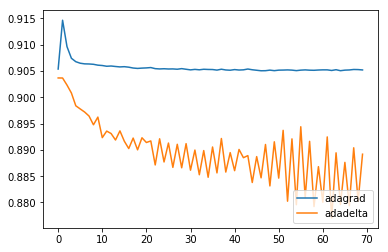

In [0]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

In [0]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=10,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=10,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(product_train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, product_test).mean())


adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(product_train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, product_test).mean())

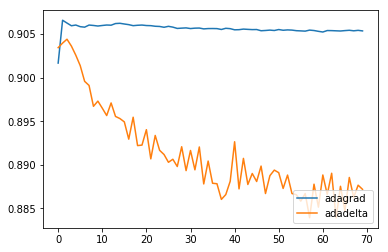

In [0]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()